This notebook applies hierarchical bayesian modeling using topographical remote sensing product

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *
import numpy as np

import optuna
import sklearn
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from src.utils import *
from src.params import *
tqdm.pandas()

%matplotlib inline

# Data Pre-Processing

In [3]:
df, basin_idx, basins, coords = read_data(file_dir='../data/hierarchical_septics_v7.csv',
        cols=['ppt_2021', 'hydraulic_c','median_hse', 'slope'], is_balanced=True, hierarchy_type='county')

/Users/juannat/Documents/research/septic/bayesian_septic/notebooks/../src/utils.py:75: DtypeWarning: Columns (8,11,13,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_dir)


balancing...
repairs: 27.73092578545258%, non-repairs: 72.26907421454743%


# Baseline Comparison

In [4]:
train_x, test_x, train_y, test_y = train_test_split(df[['ppt_2021_norm', 'hydraulic_c_norm', 'median_hse_norm', 'slope_norm']], 
                                                    df['sewageSystem_enc'], 
                                                    test_size=0.2, 
                                                    random_state=42)

### a) Aggregate Bayesian

\begin{equation*}
Y \sim Bernoulli(\theta)\tag{1}
\end{equation*}

\begin{equation*}
\theta = \sigma(\beta_{c} + \beta_{w}.waterdist + \beta_{p}.precip + \beta_{h}.hydraulics + \beta_{s}.hseval + \beta_{t}.elev) \tag{2}
\end{equation*}

\begin{equation*}
\textbf{Intercept parameters}\\
    \beta_{c} \sim N_{c}(\mu=\mu_{c}, \sigma=\theta_{c})\\
    \text{where }\mu_{c} \sim N(\mu=0, \sigma=10) \quad and \quad \theta_{c} \sim HN(\sigma=10) \tag{3}
\end{equation*}

\begin{equation*}
\textbf{Precipitation parameters}\\
    \beta_{p} \sim N_{p}(\mu=\mu_{p}, \sigma=\sigma_p)\\
    \text{where }\mu_{p} \sim N(\mu=0, \sigma=10) \quad and \quad \sigma_p \sim HN(\sigma=10) \tag{4}
\end{equation*}

\begin{equation*}
\textbf{Soil hydraulic conductivity parameters}\\
    \beta_{h} \sim N_{h}(\mu=\mu_h,\sigma=\sigma_h)\\
    \text{where }\mu_h \sim N(\mu=0, \sigma=10) \quad \sigma_h \sim HN(\sigma=10) \tag{5}
\end{equation*}

\begin{equation*}
\textbf{Socio-economic parameters}\\
    \beta_{s} \sim N_{s}(\mu=0, \sigma=\sigma_s)\\
    \text{where }\sigma_s \sim HN(\sigma=10) \tag{6}
\end{equation*}

\begin{equation*}
\textbf{Topography (elevation) parameters}\\
    \beta_{t} \sim Exp_{t}(\lambda=\lambda_t)\\
    \text{where }\lambda_t \sim HN(\sigma=10) \tag{7}
\end{equation*}

In [5]:
rs = 100
tune = 100

1. Water model: precipitation and distance to water bodies

In [6]:
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    # water_d = pm.Data('water_d', df.water_dist_norm.values)
    ppt_d = pm.Data('ppt_d', df.ppt_2021_norm.values)

    # global model parameters
    # wtr_beta = pm.HalfNormal("wtr_beta", sigma=10)
    ppt_mu = pm.Normal("ppt_mu", mu=0, sigma=10)
    ppt_sig = pm.HalfNormal("ppt_sig", sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    # wtr_dist = pm.Exponential("wtr_dist", lam=wtr_beta)
    ppt = pm.Normal("ppt", mu=ppt_mu, sigma=ppt_sig)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    # + wtr_dist * water_d 
                                    + ppt * ppt_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [c, ppt, sigma_c, mu_c, ppt_sig, ppt_mu]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 1215 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.

In [7]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 54.33905989024099 ± 0.044548762906507236%


2. Soil model

In [8]:
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values)

    # global model parameters
    hydr_mu = pm.Normal("hydr_mu", mu=0, sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    hydr = pm.Normal('hydr', mu=hydr_mu, sigma=hydr_sig)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    + hydr * hydr_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [c, hydr, sigma_c, mu_c, hydr_sig, hydr_mu]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 1351 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.

In [9]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 54.51413743736579 ± 0.06003647171705542%


3. Topo model: elevation/slope

In [6]:
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    slope_d = pm.Data('slope_d', df.slope_norm.values)

    # global model parameters
    slope_beta = pm.HalfNormal('slope_beta', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    slope = pm.Exponential('slope', lam=slope_beta)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    + slope * slope_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/pymc/data.py:406: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [slope_beta, mu_c, sigma_c, slope, c]


Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 2038 seconds.


In [7]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 51.2486815658023 ± 0.09883223342198749%


4. Socio-economic model: median housing value

In [12]:
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    hse_d = pm.Data('hse_d', df.median_hse_norm.values)

    # global model parameters
    hse_sig = pm.HalfNormal('hse_sig', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    hse = pm.Normal('hse', mu=0, sigma=hse_sig)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    + hse * hse_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [c, hse, sigma_c, mu_c, hse_sig]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 1113 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.

In [13]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 51.79561361647975 ± 0.0614130242954866%


5. Full model

In [8]:
with pm.Model(coords=coords) as model:
    print('fitting full pooled Bayesian model...')
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    # water_d = pm.Data('water_d', df.water_dist_norm.values)
    ppt_d = pm.Data('ppt_d', df.ppt_2021_norm.values)
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values)
    hse_d = pm.Data('hse_d', df.median_hse_norm.values)
    slope_d = pm.Data('slope_d', df.slope_norm.values)

    # global model parameters
    # wtr_beta = pm.HalfNormal("wtr_beta", sigma=10)
    ppt_mu = pm.Normal("ppt_mu", mu=0, sigma=10)
    ppt_sig = pm.HalfNormal("ppt_sig", sigma=10)
    hydr_mu = pm.Normal("hydr_mu", mu=0, sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=10)
    slope_beta = pm.HalfNormal('slope_beta', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    # wtr_dist = pm.Exponential("wtr_dist", lam=wtr_beta)
    ppt = pm.Normal("ppt", mu=ppt_mu, sigma=ppt_sig)
    hydr = pm.Normal('hydr', mu=hydr_mu, sigma=hydr_sig)
    hse = pm.Normal('hse', mu=0, sigma=hse_sig)
    slope = pm.Exponential('slope', lam=slope_beta)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    # + wtr_dist * water_d 
                                    + ppt * ppt_d
                                    + hydr * hydr_d
                                    + hse * hse_d
                                    + slope * slope_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/pymc/data.py:406: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Only 100 samples in chain.


fitting full pooled Bayesian model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ppt_mu, ppt_sig, hydr_mu, hydr_sig, hse_sig, slope_beta, mu_c, sigma_c, ppt, hydr, hse, slope, c]


Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 2273 seconds.


In [9]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 55.065274930844396 ± 0.05560421483561337%


In [16]:
graph = pm.model_graph.model_to_graphviz(model)
graph.render(filename='../docs/pooled')

'../docs/pooled.pdf'

In [9]:
# Edit the graph
from graphviz import Source
filename='../docs/pooled'
graph = Source.from_file(filename)
graph.render(filename=filename)

'../docs/pooled.pdf'

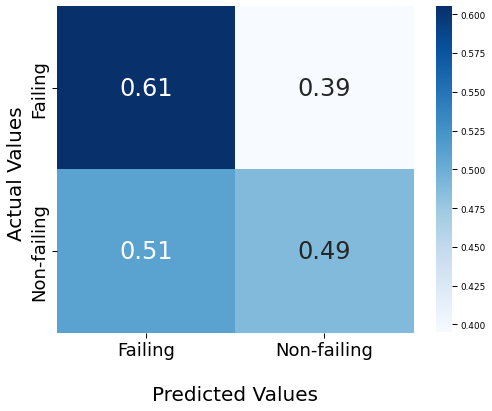

In [10]:
plot_confusion(y, y_pred, title='', savedir='../docs/confusion_l0.pdf')

## Hyperparameter Optimization

In [10]:
# hyperparameter optimization with optuna
def objective(trial, classifier_name):
    assert classifier_name in ['SVC']
    if classifier_name == 'SVC':
        svc_deg = trial.suggest_int('svc_deg', 1, 10)
        svc_c = trial.suggest
        classifier_obj = SVC(degree=svc_deg, gamma='auto')
        
    score = sklearn.model_selection.cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [ ]:
# Optimize SVC
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, classifier_name='SVC'), n_trials=10)

## Optimized Baseline Analysis

### b) Logistic Regressor

accuracy for LR: 57.37810945273631 ± 0.0 %


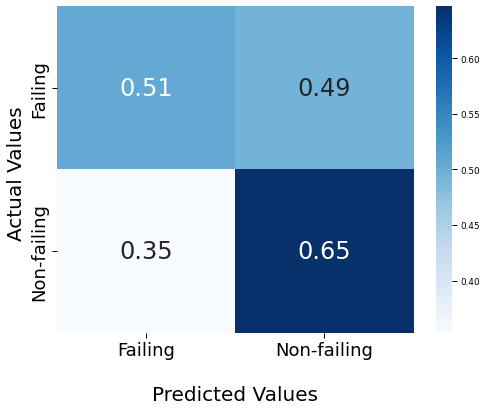

In [11]:
from sklearn.linear_model import LogisticRegression

accs = []
for i in range(5):
    lr = LogisticRegression()
    lr.fit(train_x, train_y)
    pred = lr.predict(test_x)
    acc = (pred == test_y).sum() / len(pred)
    accs.append(acc)

print(f'accuracy for LR: {np.array(accs).mean() * 100} ± {np.array(accs).std() * 100} %')

plot_confusion(test_y, pred, title='', savedir='../docs/confusion_lr.pdf')

### c) SVC

accuracy for SVC: 57.40298507462687 ± 0.0 %


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


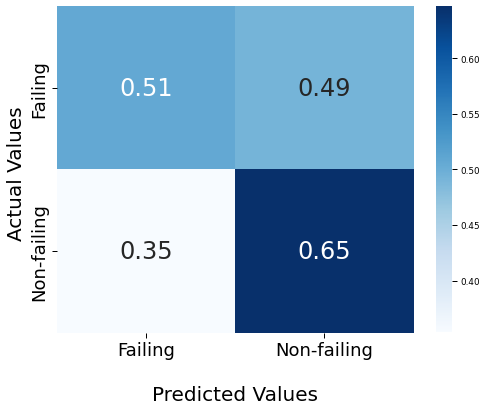

In [10]:
# SVC
accs = []
for i in range(5):
    svc_clf = LinearSVC()
    svc_clf.fit(train_x, train_y)
    svc_y_pred = svc_clf.predict(test_x)
    acc = (svc_y_pred == test_y).sum() / len(svc_y_pred)
    accs.append(acc)

print(f'accuracy for SVC: {np.array(accs).mean() * 100} ± {np.array(accs).std() * 100} %')

plot_confusion(test_y, svc_y_pred, title='', savedir='../docs/confusion_svc.pdf')